In [1]:
print("*** Importing Modules")

__author__ = "Numerical Analysis Intelligence (NumbersAI) Group"

import re
import datetime as dt

try: 
    import numpy as np
except ImportError as e:
    !pip install numpy
    
try:
    import pandas as pd
    pd.options.mode.chained_assignment = None  # default='warn'
except ImportError as e:
    !pip install pandas
try:
    import matplotlib.pyplot as plt
except ImportError as e:
    !pip install matplotlib
    
print("*** Import Complete")


*** Importing Modules
*** Import Complete


In [2]:
print("*** Loading Data")

chat_log_file = './logs/chat.log'

with open(chat_log_file) as f:
    lines = f.readlines()
                      
print("*** Loading Complete")

*** Loading Data
*** Loading Complete


In [3]:
print("*** Preprocess Data")

def process_line(line):
    
    if line is None or line=="":
        return()
    
    message_regex = '^(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4}).+:(.*)\!.*@.*\.tmi\.twitch\.tv PRIVMSG #(.*) :(.*)'

    try:
        timestamp, username, channel, message = re.search(message_regex, line).groups()
    except:
        return(None)
    
    message = re.sub(' +', ' ', message)
    tokens = message.split()
    token_count = len(tokens)
    spinny_count = len([token for token in tokens if token=='hermitSpinnyKitty'])
    
    return(timestamp, username,message,token_count,spinny_count)

timestamp_format = '%Y-%m-%dT%H:%M:%S%z'
regex_time_stamp = '^(\d{4}-\d{2}-\d{2}T\d{2}:\d{2}:\d{2}-\d{4})'

repaired_lines = list()
previous_timestamp = ""

for line in lines:
    try:
        timestamp = re.search(regex_time_stamp, line).groups()
        previous_timestamp = timestamp[0]
        repaired_lines.append(line)
    except Exception as e:
        if line is not None or line!="":
            repaired_line = "{0} — {1}".format(previous_timestamp,line)
            repaired_lines.append(repaired_line)
    
processed_chat = list()
for line in repaired_lines:
    try:
        timestamp_str, username, message, token_count, spinny_count = process_line(line)
        timestamp = dt.datetime.strptime(timestamp_str,timestamp_format)
        processed_message = dict()
        processed_message['time'] = timestamp
        processed_message['user'] = username
        processed_message['token_count'] = token_count
        processed_message['spinny_count'] = spinny_count
        processed_message['message'] = message
        processed_chat.append(processed_message)
    except Exception as e:
        continue

chatDF = pd.DataFrame.from_dict(processed_chat)

print("*** Processing Complete")

*** Preprocess Data
*** Processing Complete


In [4]:
print("*** All Chat" )
chatDF.describe()

*** All Chat


,token_count,spinny_count
count,10286.000000,10286.000000
mean,7.506125,0.224577
std,6.949496,2.014995
min,1.000000,0.000000
25%,3.000000,0.000000
50%,6.000000,0.000000
75%,9.000000,0.000000
max,88.000000,24.000000


print("*** Shape of the Dataframe")
chatDF.shape

In [5]:
print("*** Time Range")
chatDF['time'].sort_values()

*** Time Range


0       2022-12-02 19:54:28-06:00
1       2022-12-02 19:54:30-06:00
2       2022-12-02 19:54:52-06:00
3       2022-12-02 19:55:21-06:00
4       2022-12-02 19:55:47-06:00
                   ...           
10281   2022-12-10 06:09:52-06:00
10282   2022-12-10 06:09:54-06:00
10283   2022-12-10 06:10:10-06:00
10284   2022-12-10 06:10:11-06:00
10285   2022-12-10 06:10:11-06:00
Name: time, Length: 10286, dtype: datetime64[ns, UTC-06:00]

In [1]:
spinnyKitty = 'hermitSpinnyKitty'

spinnyDF = chatDF[chatDF['message'].str.contains(spinnyKitty)]
spinnyDF

NameError: name 'chatDF' is not defined

<AxesSubplot: xlabel='Train Level Reached', ylabel='Time'>

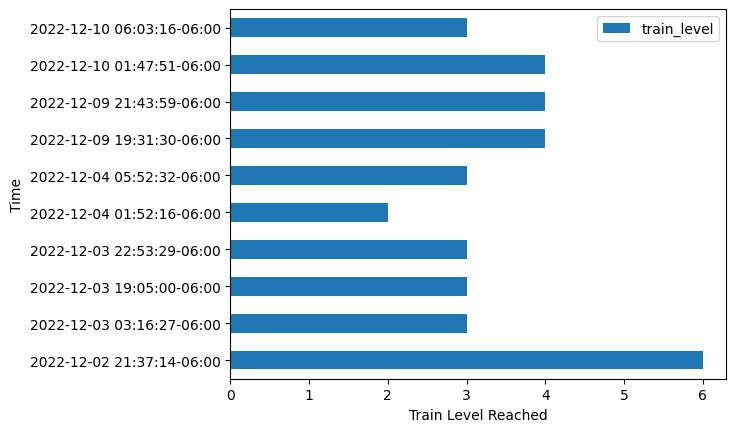

In [7]:
train = 'Hype Train STARTED|Hype Train ENDED'

trainDF = chatDF[chatDF['message'].str.contains(train)]

train_ended = 'Hype Train ENDED'
regex_train_level = 'reached\sLevel\s(\d+)'

trainEndDF = trainDF[trainDF['message'].str.contains(train_ended)]

def get_train_level(message):
    train_level = 1
    
    try:
        if 'ENDED' in message:
            train_level = int(re.search(regex_train_level, message).groups()[0])
    except ValueError:
        return(pd.np.nan)
    try:
        return train_level if train_level else pd.np.nan
    except KeyError:
        return(pd.np.nan)
    
unique_messages = trainEndDF['message'].unique()
unique_messages = pd.Series(unique_messages, index = unique_messages)

trainEndDF['train_level'] = trainEndDF['message'].map(unique_messages.apply(get_train_level))

graphTrainLevels = trainEndDF[['time', 'train_level']]
graphTrainLevels.set_index("time",drop=True,inplace=True)
graphTrainLevels.plot.barh(ylabel='Time', xlabel='Train Level Reached')

In [17]:
from ircchat import chat_frame

In [18]:
frame = chat_frame()

In [19]:
frame_results = list()

for record in chatDF.to_dict('record'):
    frame.add_message(record)
    if frame.is_ready:
        frame_profile_dict = dict()
        frame_profile_dict['time_range'] = frame.time_range
        frame_profile_dict['distinct_user_count'] = frame.distinct_user_count
        frame_profile_dict['mean_tokens'] = frame.mean_tokens
        frame_profile_dict['mean_spinny'] = frame.mean_spinny
        frame_results.append(frame_profile_dict)
        
chatFrameDF = pd.DataFrame.from_dict(frame_results)

/var/folders/yy/bcln977j2rbdw0jj3fzvdd3r0000gp/T/ipykernel_1144/1279029937.py:3: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  for record in chatDF.to_dict('record'):


In [20]:
print("*** Assigning Classifiction")

# The classification label assignment logic function

def assign_class(frame):

    condition = 0
    if frame.time_range <=30:
        condition += 1
    if frame.distinct_user_count >=3:
        condition += 1
    if frame.mean_tokens >=6:
        condition += 1
    if frame.mean_spinny >=4:
        condition += 1
    if condition == 4:
        return(1)
    else:
        return(0)

# Define the lambda for the pandas apply
assign_class_funct = lambda x: assign_class(x)

chatFrameDF['Class'] = chatFrameDF.apply(assign_class_funct,axis=1).astype('category')
print("*** Classifiction Complete")


*** Assigning Classifiction
*** Classifiction Complete


In [21]:
chatFrameDF

,time_range,distinct_user_count,mean_tokens,mean_spinny,Class
0,79.0,0,9.2,0.0,0
1,100.0,0,11.2,0.0,0
2,127.0,0,8.6,0.0,0
3,119.0,0,8.4,0.0,0
4,94.0,0,7.6,0.0,0
...,...,...,...,...,...
10277,31.0,0,3.2,0.0,0
10278,20.0,0,3.6,0.0,0
10279,26.0,0,3.0,0.0,0
10280,24.0,0,3.0,0.0,0


In [22]:
print("*** Importing Machine Learning Modules")

# Import Scikit-learn helper functions
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Import Scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB

# Import Scikit-learn metric functions
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

print("*** Import Complete")


*** Importing Machine Learning Modules
*** Import Complete


In [23]:
# Split the data
print('*** Splitting Data ***')

test_ratio = .2
train_d, test_d = train_test_split(chatFrameDF, test_size=test_ratio, random_state=42)

train_labels = train_d.Class
test_labels = test_d.Class

print('*** Data Split Complete ***')

*** Splitting Data ***
*** Data Split Complete ***


In [24]:
print('*** Build Model ***')

features = ['time_range','distinct_user_count','mean_tokens','mean_spinny']

train_data = train_d.loc[:,features].values
test_data = test_d.loc[:,features].values
    
model = GaussianNB()
model.fit(train_data,train_labels)

print('*** Model Complete ***')

*** Build Model ***
*** Model Complete ***


In [25]:
print('*** Check Accuracy ***')

from sklearn import metrics

spinny_pred = model.predict(test_data)
print("Accuracy:",metrics.accuracy_score(test_labels, spinny_pred))

print('*** Check Complete ***')

*** Check Accuracy ***
Accuracy: 0.9907632474477395
*** Check Complete ***


In [131]:
print('*** Saving Model ***')

import pickle

pickle.dump(model,open('spinnyKitty.pkl', 'wb'))

print('*** Saving Complete ***')


*** Saving Model ***
*** Saving Complete ***


In [29]:
model.predict([[5.0, 1, 4, 12]])

array([1])